# Transrotation and Back for Cuboid

As we want to rotate an entire point cloud to be aligned with the axes in a certain way, the best way to do it independently of the point cloud input is to rotate and align the bounding box of the point cloud. This rotation and alignment can be imitated with a cuboid, which we will assume to be the bounding box of the point cloud, and its respective back translation adn rotation to be aligned with the axes.

## Imports and Functions

Here you can find the libraries used and subsequently also the functions used in this notebook to keep a cleaner and non-reptitive code.

In [47]:
# For paths
import os 

# For data processing
import numpy as np
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

# Setting the root for this repo
ROOT = os.path.realpath("..")

# Creating/ Making the point cloud
def makePC(point_data, color_data=np.array([])):
    pcd = o3d.geometry.PointCloud() #Create PC object
    pcd.points = o3d.utility.Vector3dVector(point_data) #Give coordinates
    #Coloring the PC
    if len(color_data) == 0:
        pcd.paint_uniform_color([1, 0, 0])
    else:
        pcd.colors = o3d.utility.Vector3dVector(color_data)
    return pcd

# Axis alignment of given point cloud
def axisAlignment(main_pcd):
    """Rotating/axis aligning the pointcloud
    input: main_pcd = initial pointcloud (open3d.geometry.PointCloud object)
    output: main_pcd = rotated pointcloud (open3d.geometry.PointCloud object)"""
    bbox = main_pcd.get_oriented_bounding_box()
    inverse_R = np.linalg.inv(bbox.R)
    main_pcd.rotate(inverse_R)
    return main_pcd

def align_with_axes(bounding_box):
    '''
    This we might not end up needing, but I found this artifact in one of Kristin scripts and wanted to test whether it helps.
    '''
    u, s, vh = np.linalg.svd(bounding_box)
    rotation_matrix = vh.T @ u.T
    aligned_bounding_box = bounding_box @ rotation_matrix
    return aligned_bounding_box, rotation_matrix

def create_edge_vectors(cuboid_corner_coords):
    '''
    Creates the appropriate corner to corner vectors to be displayed, based on corner coordinates.
    '''
    edge_vectors = np.array([
        cuboid_corner_coords[1]-cuboid_corner_coords[0], 
        cuboid_corner_coords[3]-cuboid_corner_coords[0],
        cuboid_corner_coords[1]-cuboid_corner_coords[0],
        cuboid_corner_coords[2]-cuboid_corner_coords[1],
        cuboid_corner_coords[5]-cuboid_corner_coords[1],
        cuboid_corner_coords[3]-cuboid_corner_coords[2],
        cuboid_corner_coords[6]-cuboid_corner_coords[2],
        cuboid_corner_coords[7]-cuboid_corner_coords[3],
        cuboid_corner_coords[5]-cuboid_corner_coords[4],
        cuboid_corner_coords[7]-cuboid_corner_coords[4],
        cuboid_corner_coords[6]-cuboid_corner_coords[5],
        cuboid_corner_coords[7]-cuboid_corner_coords[6]
        ])
    return np.squeeze(edge_vectors)

# Create rotation matrix based on angle and axis
def create_rot_mat(theta, axis):
    '''
    Creates a 3x3-Rotation matrix based on rotation angle (theta) and string specification of the rotation-axis. 
    '''
    theta = math.radians(theta)
    if axis == 'x':
        rot_mat = [
            [1,     0,              0             ],
            [0,     np.cos(theta),  -np.sin(theta)],
            [0,     np.sin(theta),  np.cos(theta) ]
        ]
    elif axis == 'y':
        rot_mat = [
            [np.cos(theta),     0,      np.sin(theta)],
            [0,                 1,      0            ],
            [-np.sin(theta),    0,      np.cos(theta)]
        ]
    elif axis == 'z':
        rot_mat = [
            [np.cos(theta),     -np.sin(theta),     0],
            [np.sin(theta),     np.cos(theta),      0],
            [0,                 0,                  1]
        ]
    else:
        rot_mat = 0
        print("Rotation axis was not defined properly")
    return np.array(rot_mat)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    Returns the 1x3-unit vector of the given vector.
    '''
    return vector / np.linalg.norm(vector)

# Form single rotation matrix from Rx, Ry and Rz
def combine_rot_mats(Rx, Ry, Rz):
    '''
    Construction of single 3x3-Rotation matrix based on the three individual Rotation matrices around each axis. 
    '''
    if (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)):
        Rx, Ry, Rz = np.array(Rx), np.array(Ry), np.array(Rz)
    total_rot_mat = np.matmul(np.matmul(Rx, Ry), Rz)
    return total_rot_mat

# Determine coordinates of center of given cuboid corner coordinates
def get_cuboid_center(cuboid_corner_coordinates):
    '''
    Creates 1x3-coordiantes of the cuboid center, based on its corner values.
    '''
    center_x_coord = np.mean(cuboid_corner_coordinates[:,0])
    center_y_coord = np.mean(cuboid_corner_coordinates[:,1])
    center_z_coord = np.mean(cuboid_corner_coordinates[:,2])
    return np.array([center_x_coord, center_y_coord, center_z_coord])

# Determining the rotation matrix based on axis of rotation and angle
def create_axis_angle_rot_mat(axis_unit_vec, angle):
    '''
    Creates a 3x3-Rotation matrix based on given axis of rotation and rotation angle.
    
    Inputs:
    - axis_unit_vec:    unit vector of rotation axis | 1x3 np.ndarray
    - angle:            rotation angle by which 
    '''
    R = [
        [   np.cos(angle) + axis_unit_vec[0]**2*(1-np.cos(angle)),                                      #0,0
            axis_unit_vec[0]*axis_unit_vec[1]*(1-np.cos(angle)) - axis_unit_vec[2]*np.sin(angle),       #0,1
            axis_unit_vec[0]*axis_unit_vec[2]*(1-np.cos(angle)) + axis_unit_vec[1]*np.sin(angle)    ],  #0,2
        
        [   axis_unit_vec[1]*axis_unit_vec[0]*(1-np.cos(angle)) + axis_unit_vec[2]*np.sin(angle),       #1,0
            np.cos(angle) + axis_unit_vec[1]**2*(1-np.cos(angle)),                                      #1,1
            axis_unit_vec[1]*axis_unit_vec[2]*(1-np.cos(angle)) - axis_unit_vec[0]*np.sin(angle)    ],  #1,2
        
        [   axis_unit_vec[2]*axis_unit_vec[0]*(1-np.cos(angle)) - axis_unit_vec[1]*np.sin(angle),       #2,0
            axis_unit_vec[2]*axis_unit_vec[1]*(1-np.cos(angle)) + axis_unit_vec[0]*np.sin(angle),       #2,1
            np.cos(angle) + axis_unit_vec[2]**2*(1-np.cos(angle))                                   ]   #2,2
    ]
    return np.array(R)

# Quick function to return the norm/ length of the vector 
def norm_vec(vector):
    return np.linalg.norm(vector)

## Cuboid Definition

Below you can find the definition of a cube, whose center is the origin.

In [48]:
# Defining corner points for cuboid
cuboid_corner_coords = np.array([
    [-4, 2, -0.5],     #0
    [4, 2, -0.5],      #1
    [4, -2, -0.5],     #2
    [-4, -2, -0.5],    #3
    [-4, 2, 0.5],     #4
    [4, 2, 0.5],      #5
    [4, -2, 0.5],     #6
    [-4, -2, 0.5]     #7
])

# Defining corner connections for edges
edges = [
    [0, 1],     #0
    [0, 3],     #1
    [0, 4],     #2
    [1, 2],     #3
    [1, 5],     #4
    [2, 3],     #5
    [2, 6],     #6
    [3, 7],     #7
    [4, 5],     #8
    [4, 7],     #9
    [5, 6],     #10
    [6, 7]      #11
]

## Cuboid Visualization

In order to make sure the cuboid definition was done as expected, below you can find a visualizaiton of the defined cuboid in blue. The center should be at the origin and it should be aligned with the axes.

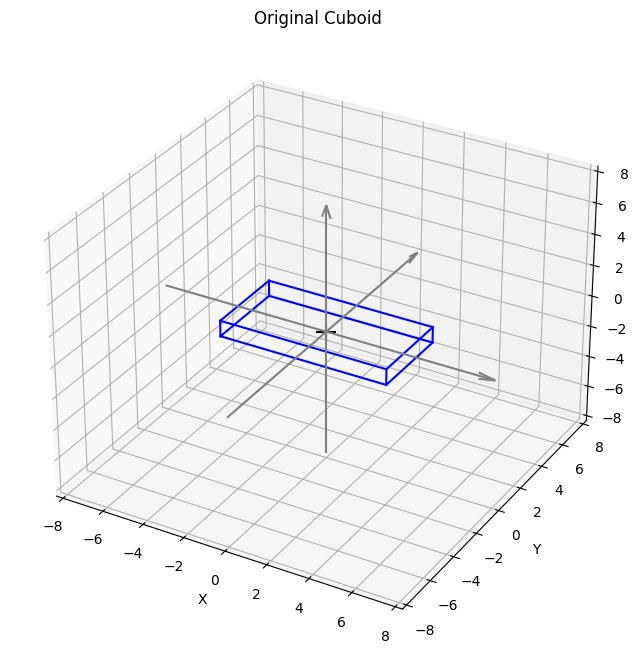

In [49]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Original Cuboid')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting edges of the cuboid
for edge in edges:
    x = [cuboid_corner_coords[edge[0]][0], cuboid_corner_coords[edge[1]][0]]
    y = [cuboid_corner_coords[edge[0]][1], cuboid_corner_coords[edge[1]][1]]
    z = [cuboid_corner_coords[edge[0]][2], cuboid_corner_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Display of only corner points without edges

Just for visualization purposes, below you can find a visualizaiton of the corner points of the cuboid without the defined edges.

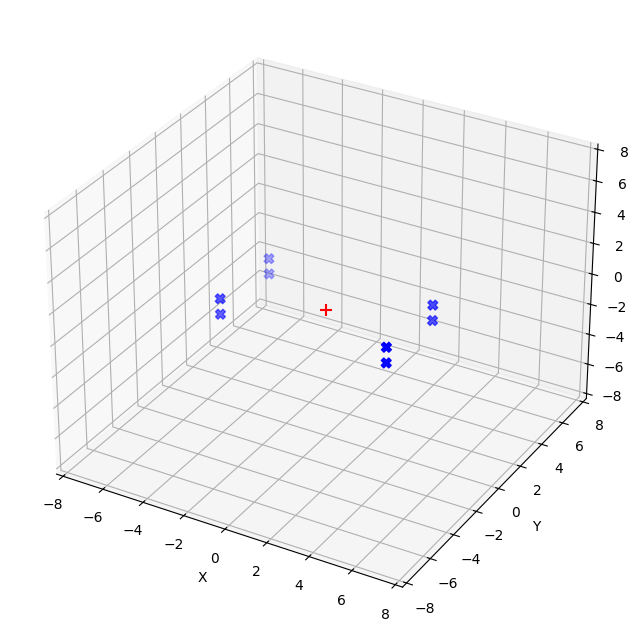

In [50]:
# Visualizing the created cuboid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Limits and axes descriptions
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Origin (red +)
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='red', 
           s=80)

# Cuboid corner points (blue X)
ax.scatter(xs=cuboid_corner_coords[:,0],
           ys=cuboid_corner_coords[:,1],
           zs=cuboid_corner_coords[:,2],
           marker='X', 
           c='blue', 
           s=50)

# Sides of cuboid (blue)
# ax.plot(xs=cuboid_corner_coords[:,0],
#         ys=cuboid_corner_coords[:,1],
#         zs=cuboid_corner_coords[:,2]
#         )

plt.show()

## Cuboid Rotation

In order to test the backrotation to the orientation we desire, we first have to rotate the cuboid out of its initially aligned position. This can be done below, by specifying the three rotation angles *theta1*, *theta3* and *theta3*.

In [51]:
# Definition of rotation angles
theta1, theta2, theta3 = 25, 30, 5

# Creation of the rotation matrics
Rx = create_rot_mat(theta1, 'x')
Ry = create_rot_mat(theta2, 'y')
Rz = create_rot_mat(theta3, 'z')
R = combine_rot_mats(Rx, Ry, Rz)

# Rotate the cuboid
rotated_cuboid_corner_coords_list = []
for i in range(len(cuboid_corner_coords)):
    x_rot_cuboid_corner_coords = cuboid_corner_coords[i].T @ Rx
    xy_rot_cuboid_corner_coords = x_rot_cuboid_corner_coords @ Ry
    xyz_rot_cuboid_corner_coords = xy_rot_cuboid_corner_coords @ Rz
    rotated_cuboid_corner_coords_list.append(xyz_rot_cuboid_corner_coords)
rotated_cuboid_corner_coords = np.array(rotated_cuboid_corner_coords_list)

### Cuboid rotation with combined rotation matrix

This was more a small test for ourselves to see whether the sequential rotation of the cuboid with sequential rotation matrices is the same as the combined sequential rotation with a single combined rotation matrix. 

In [52]:
# Visualize rotation with combined matrix
R = combine_rot_mats(Rx, Ry, Rz)
R_rotated_cuboid_corner_coords_list = []
for i in range(len(cuboid_corner_coords)):
    rot_cuboid_corner_coords = cuboid_corner_coords[i].T @ R
    R_rotated_cuboid_corner_coords_list.append(rot_cuboid_corner_coords)
R_rotated_cuboid_corner_coords = np.array(R_rotated_cuboid_corner_coords_list)

## Rotated Cuboid Visualization

Below you can find the visual check for whether the rotation of the cuboid along the specified angles worked as expected. Generally, one will see a rotated cube in blue with the center still being at the origin.

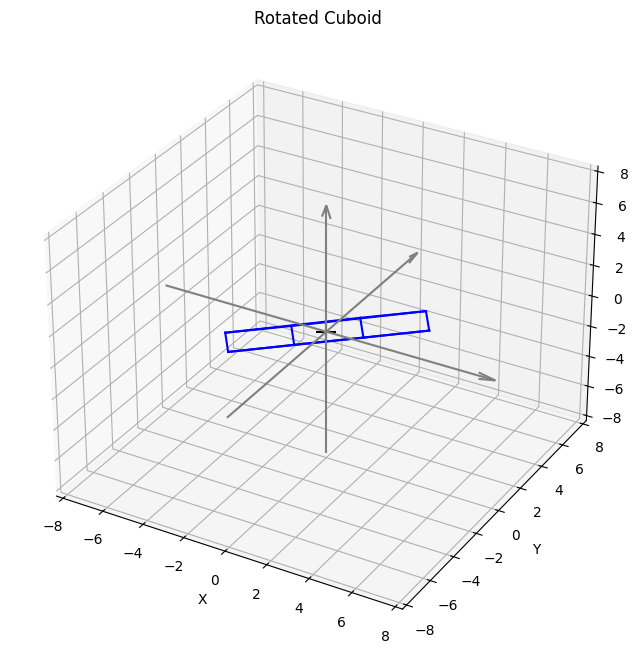

In [53]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Rotated Cuboid')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting edges of the cuboid rotated by Rx, Ry, Rz
for edge in edges:
    x = [rotated_cuboid_corner_coords[edge[0]][0], rotated_cuboid_corner_coords[edge[1]][0]]
    y = [rotated_cuboid_corner_coords[edge[0]][1], rotated_cuboid_corner_coords[edge[1]][1]]
    z = [rotated_cuboid_corner_coords[edge[0]][2], rotated_cuboid_corner_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')
    
    
# # Painting edges of the cuboid by combined R
# for edge in edges:
#     x = [R_rotated_cuboid_corner_coords[edge[0]][0], R_rotated_cuboid_corner_coords[edge[1]][0]]
#     y = [R_rotated_cuboid_corner_coords[edge[0]][1], R_rotated_cuboid_corner_coords[edge[1]][1]]
#     z = [R_rotated_cuboid_corner_coords[edge[0]][2], R_rotated_cuboid_corner_coords[edge[1]][2]]
#     ax.plot(x, y, z, 'r-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Rotated Cuboid Translation

As the point clouds and therefore also the bounding boes we work with will not only be rotated randomly, but assumingly also positioned randomly in place (meaning translated to a specific location), additionally we will also have to translate our rotated cuboid to a rnadom position in space. This is done below, and the translation vector can be specified if needed.

In [54]:
# Definition of translation vector
translation_vec = np.array([3, 3, 3])
translated_rotated_cuboid_coords = np.array(rotated_cuboid_corner_coords) + translation_vec

## Visualization of Rotated & Translated Cuboid

Below you can find a small visualization showing the rotated and translated cuboid in blue.

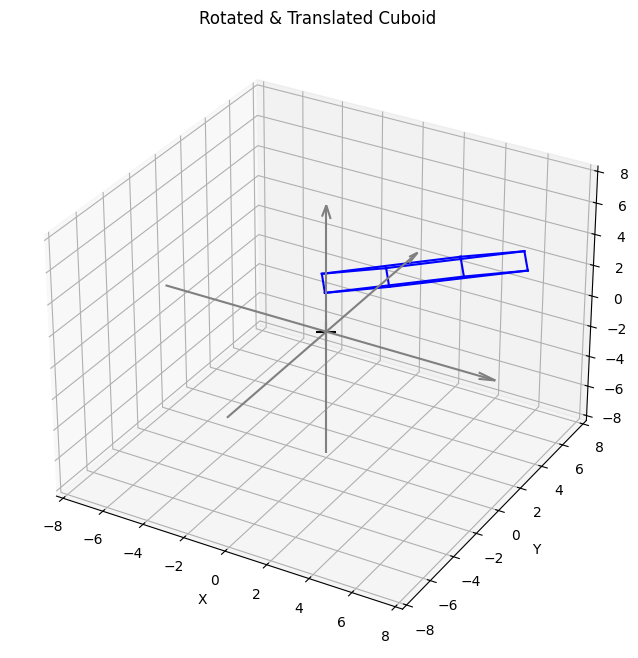

In [56]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Rotated & Translated Cuboid')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting edges of the cuboid
for edge in edges:
    x = [translated_rotated_cuboid_coords[edge[0]][0], translated_rotated_cuboid_coords[edge[1]][0]]
    y = [translated_rotated_cuboid_coords[edge[0]][1], translated_rotated_cuboid_coords[edge[1]][1]]
    z = [translated_rotated_cuboid_coords[edge[0]][2], translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Visualization of all cuboid variations

Now to double-check below you can also find a visualization of the seperate cuboids (original: blue, rotated: red and rotated and translated: green).

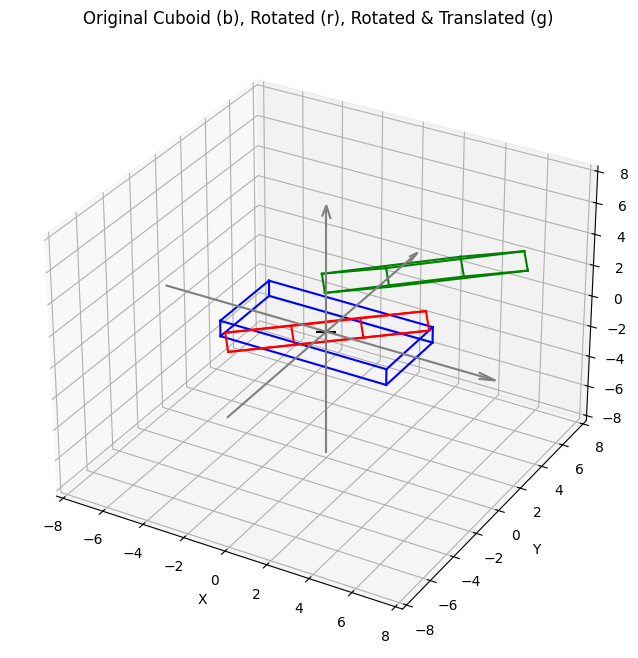

In [57]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Original Cuboid (b), Rotated (r), Rotated & Translated (g)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')


# Painting original cuboid
for edge in edges:
    x = [cuboid_corner_coords[edge[0]][0], cuboid_corner_coords[edge[1]][0]]
    y = [cuboid_corner_coords[edge[0]][1], cuboid_corner_coords[edge[1]][1]]
    z = [cuboid_corner_coords[edge[0]][2], cuboid_corner_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Painting the edges of the rotated cuboid
for edge in edges:
    x = [rotated_cuboid_corner_coords[edge[0]][0], rotated_cuboid_corner_coords[edge[1]][0]]
    y = [rotated_cuboid_corner_coords[edge[0]][1], rotated_cuboid_corner_coords[edge[1]][1]]
    z = [rotated_cuboid_corner_coords[edge[0]][2], rotated_cuboid_corner_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')

# Painting edges of the rotated and translated cuboid
for edge in edges:
    x = [translated_rotated_cuboid_coords[edge[0]][0], translated_rotated_cuboid_coords[edge[1]][0]]
    y = [translated_rotated_cuboid_coords[edge[0]][1], translated_rotated_cuboid_coords[edge[1]][1]]
    z = [translated_rotated_cuboid_coords[edge[0]][2], translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'g-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Determining orthogonal vector trio of cuboid corner

Now that we have a rotated and translated cuboid we want to pick a respective corner of the cuboid at which the orthonormal vectors of the bounding box meet. For this we just define the "lowest" corner in z-direction to be the corner of choice. From there we make all connecting lines to the rest of the corners, filter out the connection to the corner itself and then check for orthogonality to pick the correct edges. This is done by determining all the orthogonal vectors to the shortest vector/ z-edge and then subsequently deleting the longeest vector it is orthogonal with, as this will be a diagonal vector, which does not constitute a cuboid edge, and then appending the shortest edge again to have the final orthonormal vector trio.

In [58]:
# Picking lowest corner in z-direction as chosen first corner
z_value_lowest_corner = np.min(translated_rotated_cuboid_coords[:,2])
# Check if no other points have same coordinates
if len(np.where(translated_rotated_cuboid_coords == z_value_lowest_corner)) == 1:
    lowest_corner_idx = int(np.where(translated_rotated_cuboid_coords == z_value_lowest_corner)[0])
else:
    lowest_corner_idx = int(np.where(translated_rotated_cuboid_coords == z_value_lowest_corner)[0][0])
lowest_corner_coords = translated_rotated_cuboid_coords[lowest_corner_idx]

# Vector construction to all other corners
lowest_corner_to_corner_vectors = []
for i in range(len(translated_rotated_cuboid_coords)):
    lowest_corner_to_corner_vector = translated_rotated_cuboid_coords[i] - lowest_corner_coords
    if (lowest_corner_to_corner_vector == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors.append(lowest_corner_to_corner_vector)

# Determining the distances of all the vectors
vector_distances = []
for i in range(len(lowest_corner_to_corner_vectors)):
    vec_i_distance = np.linalg.norm(lowest_corner_to_corner_vectors[i])
    vector_distances.append(vec_i_distance)
# Picking shortest distance
shortest_lowest_corner_to_corner_vector = np.min(vector_distances)
shortest_lowest_corner_to_corner_vector_idx = int(
    np.where(vector_distances == shortest_lowest_corner_to_corner_vector)[0]
    )
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_lowest_corner_to_corner_vector_idx]

# Calculating the cross product to check for angle with shortest vector
orthogonal_corner_vectors_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product = np.dot(
        shortest_lowest_corner_to_corner_vector_coords, 
        lowest_corner_to_corner_vectors[i]
        )
    if dot_product <= 0.0001:
        orthogonal_corner_vectors_list.append(lowest_corner_to_corner_vectors[i])

# Filter out orthogonal vector which shouldnt be aligned with the axes
orthogonal_corner_vector_distances_list = [] 
for i in range(len(orthogonal_corner_vectors_list)):
    vec_i_distance = np.linalg.norm(orthogonal_corner_vectors_list[i])
    orthogonal_corner_vector_distances_list.append(vec_i_distance)
# Picking the longest one and deleting it
longest_orthogonal_corner_vector_distance = np.max(orthogonal_corner_vector_distances_list)
longest_orthogonal_corner_vector_idx = int(
    np.where(orthogonal_corner_vector_distances_list == longest_orthogonal_corner_vector_distance)[0]
)
# Deletion and appending of the shortest vector
del orthogonal_corner_vectors_list[longest_orthogonal_corner_vector_idx]
orthogonal_corner_vectors_list.append(shortest_lowest_corner_to_corner_vector_coords)
orthogonal_corner_vectors = np.array(orthogonal_corner_vectors_list)


/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_38486/3375444008.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_lowest_corner_to_corner_vector_idx = int(
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_38486/3375444008.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  longest_orthogonal_corner_vector_idx = int(


## Visualization of the rotated and translated cuboid with the orthogonal vectors

In order to check for the correct workings, int he visualization below you will find the rotated and trnaslated cube (in blue) and the orthonormal edges chosen colored in orange, which should overlay on one corner of the cuboid.

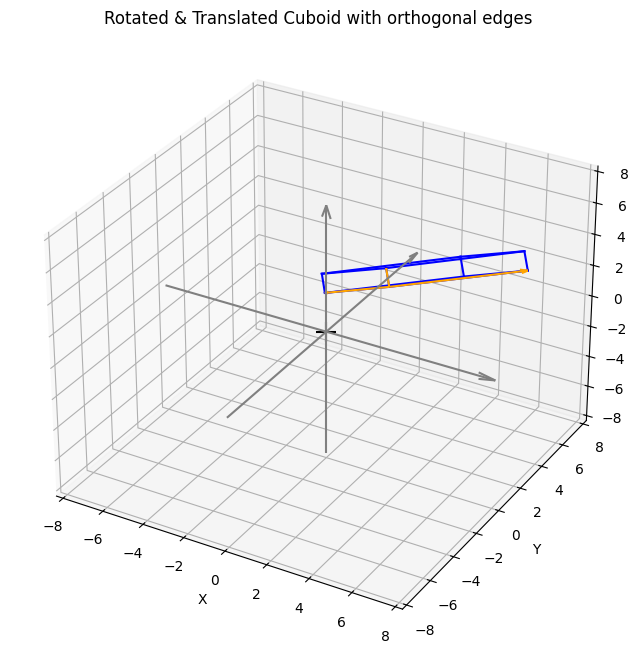

In [59]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Rotated & Translated Cuboid with orthogonal edges')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+',  
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Corner vectors as quivers
x, y, z = [lowest_corner_coords[0]] * 3, \
          [lowest_corner_coords[1]] * 3, \
          [lowest_corner_coords[2]] * 3, 
u, v, w = orthogonal_corner_vectors[:,0], \
          orthogonal_corner_vectors[:,1], \
          orthogonal_corner_vectors[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='orange')

# Painting edges of the cuboid
for edge in edges:
    x = [translated_rotated_cuboid_coords[edge[0]][0], translated_rotated_cuboid_coords[edge[1]][0]]
    y = [translated_rotated_cuboid_coords[edge[0]][1], translated_rotated_cuboid_coords[edge[1]][1]]
    z = [translated_rotated_cuboid_coords[edge[0]][2], translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Back translation of Cuboid to Origin

Before we start rotating back the cuboid we first translate it back to be centered with the origin, so that the rotation will happen around the center of the cuboid as well.

In [67]:
# Shifting back the cuboid to be centered around the origin
back_translated_rotated_cuboid_coords = translated_rotated_cuboid_coords - translation_vec

# Also translate the orthogonal vectors
back_translated_lowest_corner_coords = lowest_corner_coords - translation_vec

# Finding centre of the cuboid with averages of coordinates
cuboid_center = get_cuboid_center(translated_rotated_cuboid_coords)
# Back translation -> cuboid center is on origin -> lowest corner vector trnaslted accordingly
centered_back_translated_rotated_cuboid_coords = translated_rotated_cuboid_coords - cuboid_center
centered_back_translated_lowest_corner_coords = lowest_corner_coords - cuboid_center
#orthogonal_corner_vectors = orthogonal_corner_vectors - cuboid_center


## Visualization of back translated cuboid coords

Below you should now see the rotated and back translated cube, meaning the origin is the center, and the orthonormal vector trio (in orange). Ideally, only the red back translated cube with its orange orthonormal vector trio should be visible.

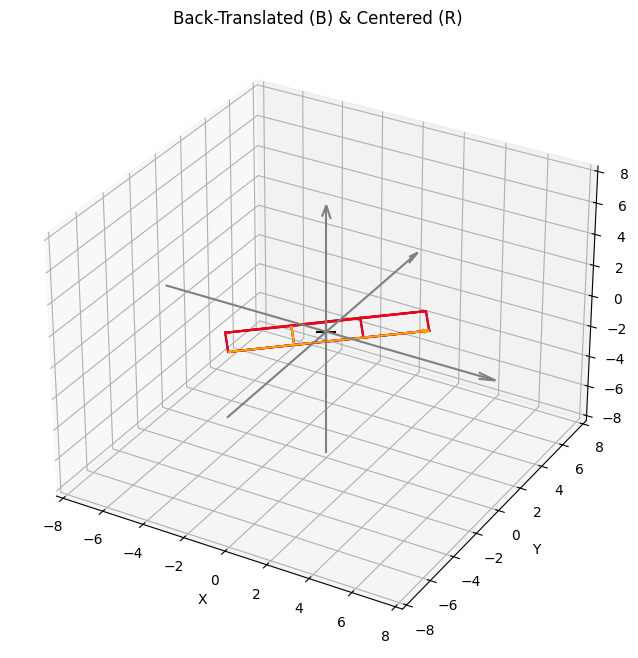

In [68]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Back-Translated (B) & Centered (R)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Corner vectors as quivers
x, y, z = [centered_back_translated_lowest_corner_coords[0]] * 3, \
          [centered_back_translated_lowest_corner_coords[1]] * 3, \
          [centered_back_translated_lowest_corner_coords[2]] * 3, 
u, v, w = orthogonal_corner_vectors[:,0], \
          orthogonal_corner_vectors[:,1], \
          orthogonal_corner_vectors[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='orange')

# Painting edges of back translated cuboid
for edge in edges:
    x = [back_translated_rotated_cuboid_coords[edge[0]][0], back_translated_rotated_cuboid_coords[edge[1]][0]]
    y = [back_translated_rotated_cuboid_coords[edge[0]][1], back_translated_rotated_cuboid_coords[edge[1]][1]]
    z = [back_translated_rotated_cuboid_coords[edge[0]][2], back_translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Painting edges of the centered translated cuboid
for edge in edges:
    x = [centered_back_translated_rotated_cuboid_coords[edge[0]][0], centered_back_translated_rotated_cuboid_coords[edge[1]][0]]
    y = [centered_back_translated_rotated_cuboid_coords[edge[0]][1], centered_back_translated_rotated_cuboid_coords[edge[1]][1]]
    z = [centered_back_translated_rotated_cuboid_coords[edge[0]][2], centered_back_translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Test with angle-axis rotation based on edge-plane angles

As our first hypothesis, we would like to rotate our cuboid based on the angles the cuboid edges form with the respective planes, to guarantee proper rotation and not over-rotation when comparing the edges with the axis themselves. First we want to align the y-edge of the cuboid with the xy-plane and rotate the cuboid around the x-axis by that angle.

### 1. First rotation -> y-edge-xy-plane rotation around x-edge

In [69]:
# Creating orthonormal vector distance list
orthogonal_corner_vector_dist_list = []
for i in range(len(orthogonal_corner_vectors)):
    vec_i_dist = np.linalg.norm(orthogonal_corner_vectors[i])
    orthogonal_corner_vector_dist_list.append(vec_i_dist)
# Determining shortest, middle and longest vector coordinates
# 1. SHORTEST
shortest_orthogonal_vector_dist = np.min(orthogonal_corner_vector_dist_list)
shortest_orthogonal_vector_idx = int(
    np.where(orthogonal_corner_vector_dist_list == shortest_orthogonal_vector_dist)[0]
    )
shortest_orthogonal_vector_coords =  orthogonal_corner_vectors[shortest_orthogonal_vector_idx]
# 2. LONGEST
longest_orthogonal_vector_dist = np.max(orthogonal_corner_vector_dist_list)
longest_orthogonal_vector_idx = int(
    np.where(orthogonal_corner_vector_dist_list == longest_orthogonal_vector_dist)[0]
    )
longest_orthogonal_vector_coords =  orthogonal_corner_vectors[longest_orthogonal_vector_idx]
# 3. MIDDLE
middle_orthogonal_vector_idx = int(
    np.where((orthogonal_corner_vector_dist_list != shortest_orthogonal_vector_coords) & \
        (orthogonal_corner_vector_dist_list != longest_orthogonal_vector_dist))[0][0]
)
middle_orthogonal_vector_coords = orthogonal_corner_vectors[middle_orthogonal_vector_idx]

# Determining the angle between y-edge (middle) and xy-plane
xy_plane_normal = np.array([0, 0, 1])
xy_plane_angle_argument = np.dot(unit_vector(middle_orthogonal_vector_coords), unit_vector(xy_plane_normal))
y_edge_xy_plane_angle_radians = np.arcsin(xy_plane_angle_argument)
# Creation of rotation matrix -> negative angle because rotating back into it
R = create_axis_angle_rot_mat(unit_vector(longest_orthogonal_vector_coords), -y_edge_xy_plane_angle_radians)
# Rotation of the cuboid points
back_translated_back_rotated_cuboid_coords_list = [] 
for i in range(len(centered_back_translated_rotated_cuboid_coords)):
    first_rot_cuboid_coords = centered_back_translated_rotated_cuboid_coords[i].T @ R
    back_translated_back_rotated_cuboid_coords_list.append(first_rot_cuboid_coords)
back_translated_back_rotated_cuboid_coords = np.array(back_translated_back_rotated_cuboid_coords_list)
# Rotation of the orthonormal vectors
rotated_orthogonal_corner_vectors_list = [] 
for i in range(len(orthogonal_corner_vectors)):
    rot_vec = orthogonal_corner_vectors[i].T @ R
    rotated_orthogonal_corner_vectors_list.append(rot_vec)
rotated_orthogonal_corner_vectors = np.array(rotated_orthogonal_corner_vectors_list)
# Rotation of originally picked corner
rot_centered_back_translated_lowest_corner_coords = centered_back_translated_lowest_corner_coords.T @ R

/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_38486/1858040123.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_orthogonal_vector_idx = int(
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_38486/1858040123.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  longest_orthogonal_vector_idx = int(


In [70]:
print(f'The angle between the y-edge and the xy-plane is: {math.degrees(y_edge_xy_plane_angle_radians)}')

The angle between the y-edge and the xy-plane is: 21.469023519778915


### Visualization of first rotation with axis angle method

Below one should find a visualization of the originally out-rotated cuboid (blue) and the result fo the first back rotation for alignment (red).

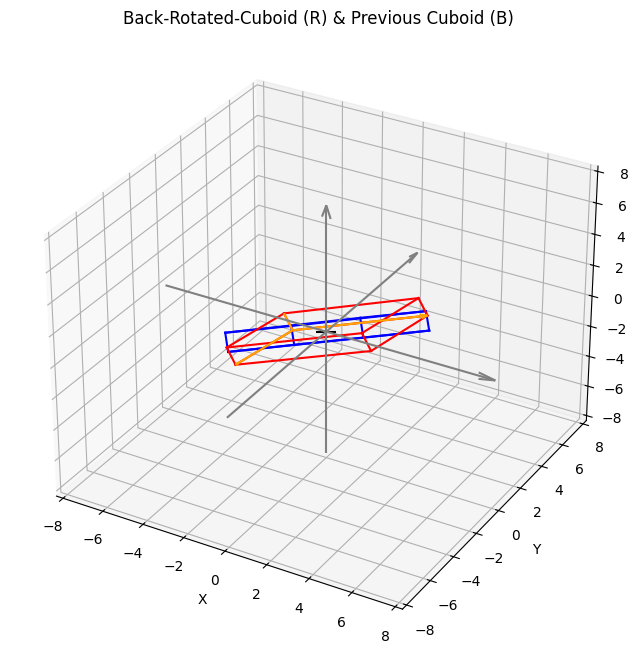

In [71]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Back-Rotated-Cuboid (R) & Previous Cuboid (B)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting the orthonormal rotated vectors
x, y, z = [rot_centered_back_translated_lowest_corner_coords[0]] * 3, \
          [rot_centered_back_translated_lowest_corner_coords[1]] * 3, \
          [rot_centered_back_translated_lowest_corner_coords[2]] * 3, 
u, v, w = rotated_orthogonal_corner_vectors[:,0], \
          rotated_orthogonal_corner_vectors[:,1], \
          rotated_orthogonal_corner_vectors[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='orange')

# Painting edges of the back-rotated cuboid 
for edge in edges:
    x = [centered_back_translated_rotated_cuboid_coords[edge[0]][0], centered_back_translated_rotated_cuboid_coords[edge[1]][0]]
    y = [centered_back_translated_rotated_cuboid_coords[edge[0]][1], centered_back_translated_rotated_cuboid_coords[edge[1]][1]]
    z = [centered_back_translated_rotated_cuboid_coords[edge[0]][2], centered_back_translated_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')
    
# Painting edges of the previous cuboid
for edge in edges:
    x = [back_translated_back_rotated_cuboid_coords[edge[0]][0], back_translated_back_rotated_cuboid_coords[edge[1]][0]]
    y = [back_translated_back_rotated_cuboid_coords[edge[0]][1], back_translated_back_rotated_cuboid_coords[edge[1]][1]]
    z = [back_translated_back_rotated_cuboid_coords[edge[0]][2], back_translated_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Centering newly rotated cuboid for next rotation around z-axis

To guarantee for correct rotation, we now center the back rotated cuboid once more.

In [72]:
# Construct the center coordinates
cuboid_center = get_cuboid_center(back_translated_back_rotated_cuboid_coords)
# Center back partly back rotated cuboid
centered_back_translated_back_rotated_cuboid_coords = back_translated_back_rotated_cuboid_coords - cuboid_center


#### Visually checking whether the centering had any effect -> Barely because we rotated around it?

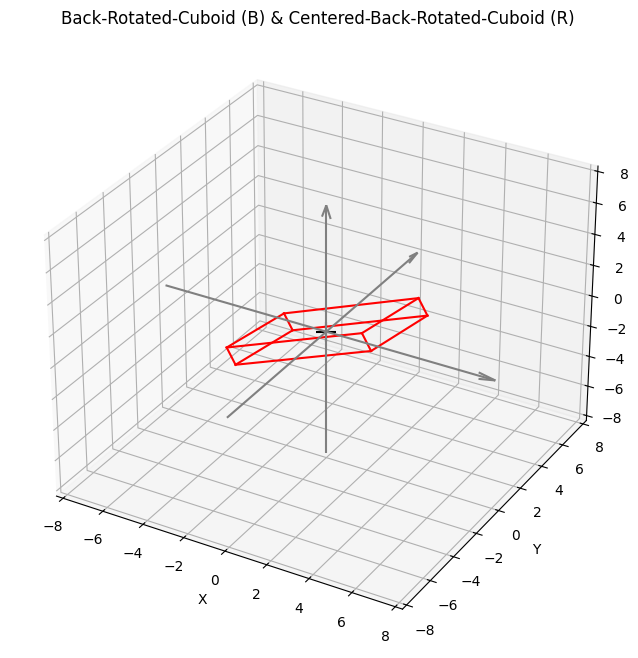

In [73]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Back-Rotated-Cuboid (B) & Centered-Back-Rotated-Cuboid (R)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting edges of the back-rotated cuboid 
for edge in edges:
    x = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][0], centered_back_translated_back_rotated_cuboid_coords[edge[1]][0]]
    y = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][1], centered_back_translated_back_rotated_cuboid_coords[edge[1]][1]]
    z = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][2], centered_back_translated_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')
    
# Painting edges of the previous cuboid
# for edge in edges:
#     x = [back_translated_back_rotated_cuboid_coords[edge[0]][0], back_translated_back_rotated_cuboid_coords[edge[1]][0]]
#     y = [back_translated_back_rotated_cuboid_coords[edge[0]][1], back_translated_back_rotated_cuboid_coords[edge[1]][1]]
#     z = [back_translated_back_rotated_cuboid_coords[edge[0]][2], back_translated_back_rotated_cuboid_coords[edge[1]][2]]
#     ax.plot(x, y, z, 'b-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Second Rotation -> y-edge-xz-plane-angle around z-axis

Now, subsequently to the first rotation we will perform the second rotation in order to align the y-edge with the xz-plane.

In [74]:
# Picking the y-edge vector
middle_orthogonal_vector_coords = rotated_orthogonal_corner_vectors[middle_orthogonal_vector_idx]

# Determining the angle with the xz-plane
xz_plane_normal = np.array([0, 1, 0])
xz_plane_argument = np.dot(unit_vector(middle_orthogonal_vector_coords), unit_vector(xz_plane_normal))
#TODO: investigate with the angle ranges
y_edge_xz_plane_angle_radians = np.pi/2 + np.arcsin(xz_plane_argument)
# Creation of Rotation Matrix
R = create_axis_angle_rot_mat(unit_vector(np.array([0, 0, 1])), -y_edge_xz_plane_angle_radians)
# Rotation of cuboid corner points
back_translated_twice_back_rotated_cuboid_coords_list = [] 
for i in range(len(centered_back_translated_back_rotated_cuboid_coords)):
    second_rot_coords = centered_back_translated_back_rotated_cuboid_coords[i].T @ R
    back_translated_twice_back_rotated_cuboid_coords_list.append(second_rot_coords)
back_translated_twice_back_rotated_cuboid_coords = np.array(back_translated_twice_back_rotated_cuboid_coords_list)
# Rotation of the orthonormal vectors
back_translated_twice_rotated_corner_vectors_list = []
for i in range(len(rotated_orthogonal_corner_vectors)):
    rot_vec = rotated_orthogonal_corner_vectors[i].T @ R
    back_translated_twice_rotated_corner_vectors_list.append(rot_vec)
back_translated_twice_rotated_corner_vectors = np.array(back_translated_twice_rotated_corner_vectors_list)
# Rotating the rotated original corner
twice_rot_centered_back_translated_lowest_corner_coords = rot_centered_back_translated_lowest_corner_coords.T @ R

In [75]:
print(f'The angle between the y-edge and the xz-plane is: {math.degrees(y_edge_xz_plane_angle_radians)}')

The angle between the y-edge and the xz-plane is: 7.422863682988655


### Visualizing the second rotation with previous cuboid

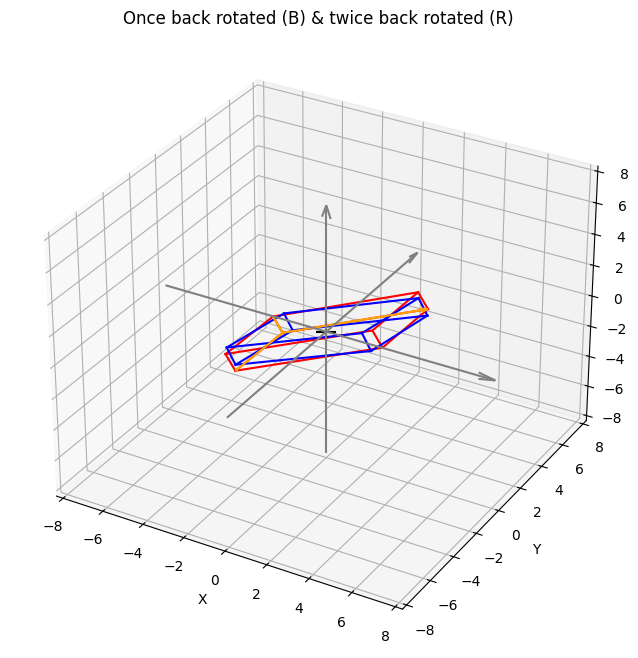

In [76]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Once back rotated (B) & twice back rotated (R)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting rotated orthogonal corner vectors
x, y, z = [twice_rot_centered_back_translated_lowest_corner_coords[0]] * 3, \
          [twice_rot_centered_back_translated_lowest_corner_coords[1]] * 3, \
          [twice_rot_centered_back_translated_lowest_corner_coords[2]] * 3, 
u, v, w = back_translated_twice_rotated_corner_vectors[:,0], \
          back_translated_twice_rotated_corner_vectors[:,1], \
          back_translated_twice_rotated_corner_vectors[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='orange')

# Painting edges of the back-rotated cuboid 
for edge in edges:
    x = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][0], back_translated_twice_back_rotated_cuboid_coords[edge[1]][0]]
    y = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][1], back_translated_twice_back_rotated_cuboid_coords[edge[1]][1]]
    z = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][2], back_translated_twice_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')
    
# Painting edges of the previous cuboid
for edge in edges:
    x = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][0], centered_back_translated_back_rotated_cuboid_coords[edge[1]][0]]
    y = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][1], centered_back_translated_back_rotated_cuboid_coords[edge[1]][1]]
    z = [centered_back_translated_back_rotated_cuboid_coords[edge[0]][2], centered_back_translated_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Third rotation -> angle x-edge and xy plane around y_edge

Lastly, we will now define the final rotation for the cuboid to be aligned with the axis. The only rotation left is to be performed in order to align the x-edge with the xy-plane.

In [79]:
# Determining the distances of the rotated corner vectors
orthonormal_rotated_corner_vectors_list = []
for i in range(len(back_translated_twice_rotated_corner_vectors)):
    vec_i_dist = np.linalg.norm(back_translated_twice_rotated_corner_vectors[i])
    orthonormal_rotated_corner_vectors_list.append(vec_i_dist)

print(orthonormal_rotated_corner_vectors_list)

[8.0, 4.0, 0.9999999999999994]


In [80]:
# Determining the distances of the rotated corner vectors
orthonormal_rotated_corner_vector_dists_list = []
for i in range(len(back_translated_twice_rotated_corner_vectors)):
    vec_i_dist = np.linalg.norm(back_translated_twice_rotated_corner_vectors[i])
    orthonormal_rotated_corner_vector_dists_list.append(vec_i_dist)

# TODO: Adjust hard coding of the middle and long vector selection!!
longest_orthogonal_rotated_vector_coords = back_translated_twice_rotated_corner_vectors[0]
middle_orthogonal_rotated_vector_coords = back_translated_twice_rotated_corner_vectors[1]


# Angle between it and xy-plane
xy_plane_normal = np.array([0, 0, 1])
xy_plane_argument = np.dot(unit_vector(longest_orthogonal_rotated_vector_coords), unit_vector(xy_plane_normal))
x_edge_xy_plane_angle_radians = np.arcsin(xy_plane_argument)
# Create Rotation Matrix
R = create_axis_angle_rot_mat(np.array([0, 1, 0]), -x_edge_xy_plane_angle_radians)
back_translated_third_back_rotated_cuboid_coords_list = []
for i in range(len(back_translated_twice_back_rotated_cuboid_coords)):
    third_rot_coords = back_translated_twice_back_rotated_cuboid_coords[i].T @ R
    back_translated_third_back_rotated_cuboid_coords_list.append(third_rot_coords)
back_translated_third_back_rotated_cuboid_coords = np.array(back_translated_third_back_rotated_cuboid_coords_list)
# Rotate orthogonal vectors and lowest corner point as well for display
back_translated_third_rotated_corner_vector_list = []
for i in range (len(back_translated_twice_rotated_corner_vectors)):
    rot_vec = back_translated_twice_rotated_corner_vectors[i].T @ R
    back_translated_third_rotated_corner_vector_list.append(rot_vec)
back_translated_third_rotated_corner_vector = np.array(back_translated_third_rotated_corner_vector_list)
# Rotating lowest corner point
third_rot_centered_back_translated_lowest_corner_coords = twice_rot_centered_back_translated_lowest_corner_coords.T @ R

In [81]:
print(f'The angle between the x-edge and the xy-plane is: {math.degrees(x_edge_xy_plane_angle_radians)}')

The angle between the x-edge and the xy-plane is: 29.999999999999996


### Visualizing third rotation

Below, the result fot he final rotation shall be displayed as the cuboid in red and the orthonormal edges in orange.

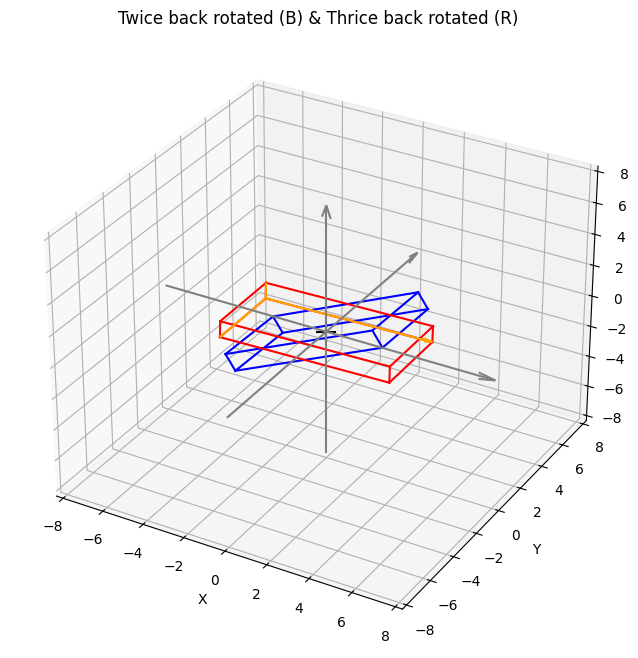

In [83]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Twice back rotated (B) & Thrice back rotated (R)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Painting third rotated orthogonal corner vectors
x, y, z = [third_rot_centered_back_translated_lowest_corner_coords[0]] * 3, \
          [third_rot_centered_back_translated_lowest_corner_coords[1]] * 3, \
          [third_rot_centered_back_translated_lowest_corner_coords[2]] * 3, 
u, v, w = back_translated_third_rotated_corner_vector[:,0], \
          back_translated_third_rotated_corner_vector[:,1], \
          back_translated_third_rotated_corner_vector[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='orange')

# Cuboid after second rotation
for edge in edges:
    x = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][0], back_translated_twice_back_rotated_cuboid_coords[edge[1]][0]]
    y = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][1], back_translated_twice_back_rotated_cuboid_coords[edge[1]][1]]
    z = [back_translated_twice_back_rotated_cuboid_coords[edge[0]][2], back_translated_twice_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')
    
# Cuboid after third rotation
for edge in edges:
    x = [back_translated_third_back_rotated_cuboid_coords[edge[0]][0], back_translated_third_back_rotated_cuboid_coords[edge[1]][0]]
    y = [back_translated_third_back_rotated_cuboid_coords[edge[0]][1], back_translated_third_back_rotated_cuboid_coords[edge[1]][1]]
    z = [back_translated_third_back_rotated_cuboid_coords[edge[0]][2], back_translated_third_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Last centering

It is not nexcessarily needed but for mathematical correctness we will center the finally back rotated cuboid once more. 

In [84]:
last_center = get_cuboid_center(back_translated_third_back_rotated_cuboid_coords)
centered_back_translated_third_back_rotated_cuboid_coords = back_translated_third_back_rotated_cuboid_coords + last_center

## Displaying original and back rotated version

In order to check for the back rotation and its effect, below you will find a visualization of the originally defined cuboid (in blue) and the back rotated cuboid (in red).

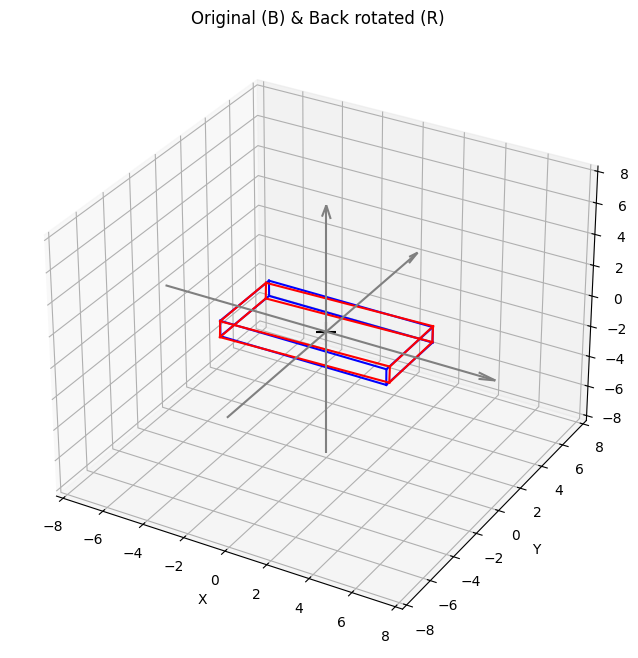

In [85]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.title('Original (B) & Back rotated (R)')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='+', 
           c='black', 
           s=200)

# Axes as quivers
x_start = [-8, 0, 0]
y_start = [0, -8, 0]
z_start = [0, 0, -8]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [16, 0, 0]
y_vec = [0, 16, 0]
z_vec = [0, 0, 16]
axes_vec = np.vstack((x_vec, 
                      y_vec, 
                      z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
          arrow_length_ratio=0.05, 
          color='grey')

# Cuboid after second rotation
for edge in edges:
    x = [cuboid_corner_coords[edge[0]][0], cuboid_corner_coords[edge[1]][0]]
    y = [cuboid_corner_coords[edge[0]][1], cuboid_corner_coords[edge[1]][1]]
    z = [cuboid_corner_coords[edge[0]][2], cuboid_corner_coords[edge[1]][2]]
    ax.plot(x, y, z, 'b-')
    
# Cuboid after third rotation
for edge in edges:
    x = [centered_back_translated_third_back_rotated_cuboid_coords[edge[0]][0], centered_back_translated_third_back_rotated_cuboid_coords[edge[1]][0]]
    y = [centered_back_translated_third_back_rotated_cuboid_coords[edge[0]][1], centered_back_translated_third_back_rotated_cuboid_coords[edge[1]][1]]
    z = [centered_back_translated_third_back_rotated_cuboid_coords[edge[0]][2], centered_back_translated_third_back_rotated_cuboid_coords[edge[1]][2]]
    ax.plot(x, y, z, 'r-')

# Limits for display
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [30]:
print(cuboid_corner_coords)
print('___________________________')
print(centered_back_translated_third_back_rotated_cuboid_coords)

[[-4.   2.  -0.5]
 [ 4.   2.  -0.5]
 [ 4.  -2.  -0.5]
 [-4.  -2.  -0.5]
 [-4.   2.   0.5]
 [ 4.   2.   0.5]
 [ 4.  -2.   0.5]
 [-4.  -2.   0.5]]
___________________________
[[-4.06951391  1.83036171 -0.58209328]
 [ 3.92512233  2.12324697 -0.57899651]
 [ 4.07138233 -1.87079776 -0.4170871 ]
 [-3.92325391 -2.16368303 -0.42018387]
 [-4.07138233  1.87079776  0.4170871 ]
 [ 3.92325391  2.16368303  0.42018387]
 [ 4.06951391 -1.83036171  0.58209328]
 [-3.92512233 -2.12324697  0.57899651]]


After printing out the corners of the resulting back rotated cuboid we can see that it almost matches up exactly with the originally defined cuboid. But somehow, either because of numerical inaccuracy or because of procedure, it does not align exactly. Therefore, a better method for the backrotation has to be found.

# Conclusion

Generally, it seems, that if done correctly, the backrotation based on this approach could/ should work. But on the other hand it also does not feel like a very stable approach, as the directionality for the angles and their rotaiton is dependent on the severity of rotation. Therefore, in order to make this a stable and reliable (back-) rotation technique, several cases for angle values and their magnitude have to be defined seperately to perform the correct rotation appropriately. In order to not undergo this difficulty, another way of rotation is wished for, that an deliver on ccuracy and reliability without going trhough the very intricate angle distinctions based on their magnitude. A promising approach was come up by finding out how to map the edge vectors onto the respective axes vectors, this shalle be investigated in line form first in a different notebook.